# A/B-тестирование новой системы оплаты на сайте

Группе B предложена новая механика оплаты услуг на сайте, при этом у контрольной группы А сохранилась прежняя механика.
<br>
Эксперимент будет длиться несколько дней. У нас есть информация пока только по первому дню эксперимента.
<br>
В таблице groups содержится информация об айди пользователей и их принадлежность к тестовой или контрольной группе.
<br>
В таблице groups_add - новые пользователи, которые пришли на сайт во время проведения эксперимента, и их принадлежность к группам. Высылается раз в день.
<br>
В таблице active_studs - айди пользователей, которые заходили на сайт во время эксперимента.
<br>
В таблице checks - айди и суммы, которые пользователи потратили на сайте во время эксперимента.
<br>
Необходимо для начала выбрать метрики, на которые может повлиять изменение. Далее - проанализировать их динамику и сделать предварительный вывод: стоит ли распространять новую механику на всех пользователей. Далее - напишем функцию, которая будет автоматически пересчитывать метрики с учетом новых данных, чтобы смотреть на динамику различий метрик и стат значимости этих различий, чтобы в итоге сделать обоснованный вывод.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats
from scipy.stats import chi2_contingency, chi2 

In [448]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [10]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [449]:
groups_add = pd.read_csv('Проект_2_group_add.csv', sep=',')
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [450]:
active_studs = pd.read_csv('Проект_2_active_studs.csv', sep=',')
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [451]:
checks = pd.read_csv('Проект_2_checks.csv', sep=';')
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [454]:
checks = checks.rename(columns={'student_id': 'id'})
checks

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [282]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Видим, что минимальная покупка составляет 199, максимальная - 4650. Среднее существенно больше медианы, посмотрим на гистограмму распределения

D:\LEON\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

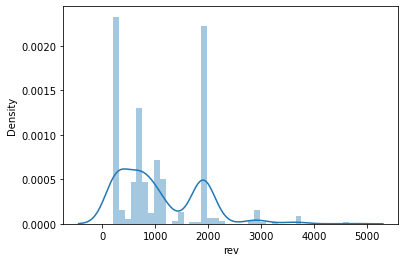

In [429]:
sns.distplot(checks.rev, bins=40)

In [428]:
checks.rev.value_counts(normalize=True)

1900.0000    0.179298
290.0000     0.173752
690.0000     0.144177
199.0000     0.085028
990.0000     0.075786
1900.0001    0.066543
840.0000     0.049908
1140.0000    0.046211
580.0000     0.027726
590.0000     0.020333
398.0000     0.016636
1530.0000    0.014787
870.0000     0.011091
3660.0000    0.009242
2910.0000    0.007394
1980.0000    0.007394
2890.0000    0.007394
1160.0000    0.005545
489.0000     0.005545
2099.0000    0.005545
1180.0000    0.003697
2820.0000    0.003697
2220.0000    0.003697
1830.0000    0.001848
1968.0000    0.001848
1050.0000    0.001848
597.0000     0.001848
630.0000     0.001848
4650.0000    0.001848
880.0000     0.001848
1039.0000    0.001848
3260.0000    0.001848
1339.0000    0.001848
3040.0000    0.001848
796.0000     0.001848
2190.0000    0.001848
1388.0000    0.001848
2900.0000    0.001848
1729.0000    0.001848
Name: rev, dtype: float64

In [433]:
checks[checks['rev'] < 1200].rev.count() / checks.rev.count()

0.6765249537892791

Видим, что общее распределение потраченных денег (включая оплаты и тестовой, и контрольной групп) двумодальное. Большое количество людей покупают на небольшие суммы до 1200 (68% пользователей), также много пользователей покупают на средние суммы около 2000 (24.5% пользователей). Гораздо реже встречаются чеки на другие суммы

Ключевые метрики для анализа, на которые может повлиять изменение механики оплаты - конверсия в покупку (пользователю легче решиться оплатить услугу) и ARPPU (у пользователя появляется стимул совершать более дорогостоящие покупки).

Одна из метрик для анализа - конверсия в покупку. Посчитаем, какой процент тех, кто заходил на сайт во время проведения эксперимента, совершил покупку, отличается ли это значения между группами и являются ли эти различия статистически значимыми

Перед этим сразу посмотрим, нет ли ошибок в выгрузке - нет ли повторяющихся айди, не присвоены ли разные группы одному и тому же айди

In [41]:
groups.id.nunique()

74484

Видим, что кол-во уникальных айди равно кол-ву строк в таблице. Можно переходить к анализу

In [35]:
df.dtypes

id          int64
grp        object
active    float64
rev       float64
dtype: object

In [452]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
groups = pd.concat([groups, groups_add])
active_studs = active_studs.merge(groups, on='id', how='left')
active_studs = active_studs.merge(checks.rename(columns={'student_id': 'id'}), on='id', how='left').fillna(0)
active_studs.head(5)

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Как мы видели раньше, минимальная сумма в таблице с оплатами - 199, поэтому заполняем нулями всех тех, кто заходил на сайт, но не совершил покупки

In [289]:
active_studs['conversion'] = active_studs['rev'].apply(lambda x: 1 if x > 0 else 0)
active_studs['status'] = active_studs['rev'].apply(lambda x: 'conversion' if x > 0 else 'not_converted')

In [290]:
active_studs.groupby('grp', as_index=False).agg({'conversion': 'mean'})

,grp,conversion
0,A,0.050715
1,B,0.046156


Конверсия в оплату увеличилась в тестовой группе на 0.5 процентных пункта. Проверим статистическую значимость. Так как обе переменные номинативные (тестовая группа и статус "сконвертировался"/"не сконвертировался"), используем таблицы сопряженности и проверим критерием хи-квадрат

In [292]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(active_studs.conversion, active_studs.grp))

In [293]:
stat, p

(0.48480826522557896, 0.48625240457231045)

Получился очень высокий пи-велью - не можем отвергнуть гипотезу об отсутствии различий. Следовательно не можем сделать вывод о том, что новая механика оплаты стат значимо не повлияла на конверсию в покупку

Следующая метрика, которую необходимо исследовать - ARPPU. Проверим, есть ли разница в среднем чеке и является ли она статистически значимой

In [455]:
checks = checks.merge(groups, on='id', how='left')
checks.head(5)

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


In [456]:
checks.groupby('grp').agg({'rev': 'mean'})

,rev
grp,
A,860.710280
B,1108.824893


<AxesSubplot:xlabel='grp', ylabel='rev'>

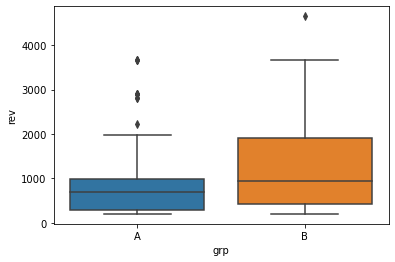

In [457]:
sns.boxplot(data=checks, x='grp', y='rev')

Видим, что средний чек в тестовой группе заметно увеличился (на 28%)

Распределение не является нормальным, поэтому применим непараметрический тест Манна-Уитни

In [458]:
scipy.stats.mannwhitneyu(checks[checks['grp'] == 'A']['rev'], checks[checks['grp'] == 'B']['rev'])

MannwhitneyuResult(statistic=17862.0, pvalue=9.658027498190076e-05)

Пи-велью очень низкий, отвергаем гипотезу о равенстве средних чеков. Новая система оплаты статистически значимо повлияла на ARPPU - средний чек в тестовой группе вырос на 248 (на 28%)

D:\LEON\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\LEON\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

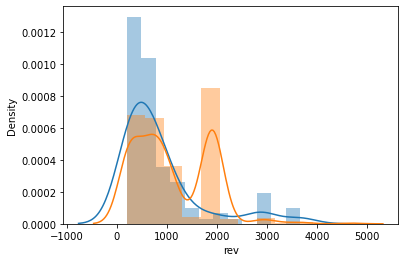

In [96]:
sns.distplot(checks.query("grp == 'A'").rev)
sns.distplot(checks.query("grp == 'B'").rev)

In [461]:
checks.query("grp == 'B' and rev < 2000 and rev >=1900") \
    .id.count() / checks.query("grp == 'A' and rev < 2000 and rev >=1900").id.count()

68.0

На графике распределения видим причину, за счет которой произошло такое изменение - благодаря новой оплате пользователи из тестовой группы стали гораздо чаще (в 68 раз) совершать крупные покупки стоимостью около 2000 по сравнению с контрольной группой. Распределение покупок пользователей из тестовой выборки стало двумодальным

Конверсия в покупку увеличилась несильно и статистически не значимо. Нет падения конверсии, что уже хорошо. При этом средний чек вырос сильно и значимо, увеличилось кол-во покупок на крупную сумму.
<br>
Предварительный вывод: новую механику стоит запускать на всех пользователей

Теперь автоматизируем анализ для последующих ежедневных обновлений метрик

Каждый день нам будут присылать новые файлы с новыми пользователями, которые заходили на сайт, и которым присваивалась контрольная или тестовая группа. Файлы называются groups_add. Напишем функцию, которая автоматически будет пересчитывать метрики и проверять их стат значимость с учетом новых пользователей

Перед первым запуском функции необходимо заново считать исходные таблицы, так как выше они были преобразованы, а функция предполагает автоматические расчеты на исходных данных.
<br>
Перед последующими запусками следует обновлять только таблицы groups_add, active_stud, checks, так как каждый день будут приходить новые.
<br>
После работы функции необходимо запустить строчку, которая контакенирует таблицы groups и groups_add и записывает их в groups.

In [421]:
def metrics(groups, groups_add, active_studs, checks, day):
    
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    groups = pd.concat([groups, groups_add])
    active_studs = active_studs.merge(groups, on='id', how='left')
    active_studs = active_studs.merge(checks.rename(columns={'student_id': 'id'}), on='id', how='left').fillna(0)
    
    active_studs['conversion'] = active_studs['rev'].apply(lambda x: 1 if x > 0 else 0)
    active_studs['status'] = active_studs['rev'].apply(lambda x: 'conversion' if x > 0 else 'not_converted')
    
    conversion = active_studs.groupby('grp', as_index=False).agg({'conversion': 'mean'})
    conversion['date'] = day
    
    stat, p_conversion, dof, expected = chi2_contingency(pd.crosstab(active_studs.conversion, active_studs.grp))
    
    if p_conversion > 0.05:
        summary_conversion = 'Различия между конверсиями статистически не значимы'
    else:
        summary_conversion = 'Различия между конверсиями статистически значимы. В тестовой группе конверсия {relations} на {percent}'
    
    p_conversion = 'p-value = {}'.format(p_conversion.round(3))
    
    if conversion[conversion['grp'] == 'B']['conversion'].values > conversion[conversion['grp'] == 'A']['conversion'].values:
        relation_conversion = 'больше'
        percent_conversion = str(int((conversion[conversion['grp'] == 'B']['conversion'].values / conversion[conversion['grp'] == 'A']['conversion'].values - 1) * 100)) + '%'
    else:
        relation_conversion = 'меньше'
        percent_conversion = str(int((conversion[conversion['grp'] == 'A']['conversion'].values / conversion[conversion['grp'] == 'B']['conversion'].values - 1) * 100)) + '%'
    
    summary_conversion = summary_conversion.format(relation=relation_conversion, percent=percent_conversion)
    
    checks = checks.rename(columns={'student_id': 'id'})
    checks = checks.merge(groups, on='id', how='left')
    
    ARPPU = checks.groupby('grp', as_index=False).agg({'rev': 'mean'}).rename(columns={'rev': 'ARPPU'})
    ARPPU['date'] = day
    
    p_shapiro_A = scipy.stats.shapiro(checks[checks['grp'] == 'A']['rev']).pvalue
    p_shapiro_B = scipy.stats.shapiro(checks[checks['grp'] == 'B']['rev']).pvalue
    
    if p_shapiro_A > 0.05 and p_shapiro_B > 0.05:
        p_check = scipy.stats.ttest_ind(checks[checks['grp'] == 'A']['rev'],
                              checks[checks['grp'] == 'B']['rev']).pvalue
    else:
        U, p_check = scipy.stats.mannwhitneyu(checks[checks['grp'] == 'A']['rev'],
                                           checks[checks['grp'] == 'B']['rev'])
        
    if p_check > 0.05:
        summary_arppu = 'Различия между ARPPU статистически не значимы.'
    else:
        summary_arppu = 'Различия между ARPPU статистически значимы. В тестовой группе ARPPU {relation} на {percent}'
    
    p_check = 'p-value = {}'.format(p_check.round(3))
    
    if ARPPU[ARPPU['grp'] == 'B']['ARPPU'].values > ARPPU[ARPPU['grp'] == 'A']['ARPPU'].values:
        relation_arppu = 'больше'
        percent_arppu = str(int((ARPPU[ARPPU['grp'] == 'B']['ARPPU'].values / ARPPU[ARPPU['grp'] == 'A']['ARPPU'].values - 1) * 100)) + '%'
    else:
        relation_arppu = 'меньше'
        percent_arppu = str(int((ARPPU[ARPPU['grp'] == 'A']['ARPPU'].values / ARPPU[ARPPU['grp'] == 'B']['ARPPU'].values - 1) * 100)) + '%'
    
    summary_arppu = summary_arppu.format(relation=relation_arppu, percent=percent_arppu)
    
    return conversion, p_conversion, summary_conversion, ARPPU, p_check, summary_arppu

In [422]:
metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))

(  grp  conversion        date
 0   A    0.050715  09-08-2022
 1   B    0.046156  09-08-2022,
 'p-value = 0.486',
 'Различия между конверсиями статистически не значимы',
   grp        ARPPU        date
 0   A   860.710280  09-08-2022
 1   B  1108.824893  09-08-2022,
 'p-value = 0.0',
 'Различия между ARPPU статистически значимы. В тестовой группе ARPPU больше на 28%')

In [ ]:
groups = pd.concat([groups, groups_add])

4 cтроки ниже запускаются единожды, чтобы создать таблицы для графиков. Позже в них будут добавляться результаты, полученные в следующие дни эксперимента. Строки закомментированны, чтобы случайно не запустить их (в таком случае все перезапишется)

In [416]:
# conversion_graph = metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[0]
# conversion_graph

,grp,conversion,date
0,A,0.050715,08-08-2022
1,B,0.046156,08-08-2022


In [366]:
# p_conversion_graph = pd.DataFrame({'date': [date.today().strftime("%d-%m-%Y")],
#                                    'p_value':[float(metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[1].split('= ')[1])]})
# p_conversion_graph

,date,p_value
0,08-08-2022,0.486


In [363]:
# arppu_graph = metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[3]
# arppu_graph

,grp,ARPPU,date
0,A,860.710280,08-08-2022
1,B,1108.824893,08-08-2022


In [364]:
# p_arppu_graph = pd.DataFrame({'date': [date.today().strftime("%d-%m-%Y")],
#                               'p_value':[float(metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[4].split('= ')[1])]})
# p_arppu_graph

,date,p_value
0,08-08-2022,0.0


Теперь добавим в уже существующие таблицы новые результаты, посчитанные функцией в очередной день эксперимента

In [423]:
conversion_graph = conversion_graph \
                    .append(metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[0])
p_conversion_graph = p_conversion_graph \
                    .append(pd.DataFrame({'date': [date.today().strftime("%d-%m-%Y")],
                                          'p_value':[float(metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[1].split('= ')[1])]}))
arppu_graph = arppu_graph \
                .append(metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[3])
p_arppu_graph = p_arppu_graph \
                .append(pd.DataFrame({'date': [date.today().strftime("%d-%m-%Y")],
                                      'p_value':[float(metrics(groups, groups_add, active_studs, checks, date.today().strftime("%d-%m-%Y"))[4].split('= ')[1])]}))

Ниже строим графики.
<br>
Левая часть: сверху - динамика конверсий в группах, снизу - пи-велью теста на стат значимость различий между конверсиями. 
<br>
Правая часть: сверху - динамика ARPPU в группах, снизу - пи-велью теста на стат значимость различий между ними.

Эксперимент будет длиться несколько дней, и если один раз пи-велью окажется ниже красной пунктирной линии (альфа, равное 0.05), это еще не значит, что можно останавливать эксперимент. К концу эксперимента надо убедиться, что пи-велью последовательно находится ниже порогового значения. Только тогда после установленного срока проведения эксперимента можно будет сделать вывод о том, что новую механику можно точно распространять на всех. 
<br>
Сейчас на графике значения за 2 дня по каждому показателю совпадают, так как основаны на тех же самых данных - это сделано исключительно для наглядности

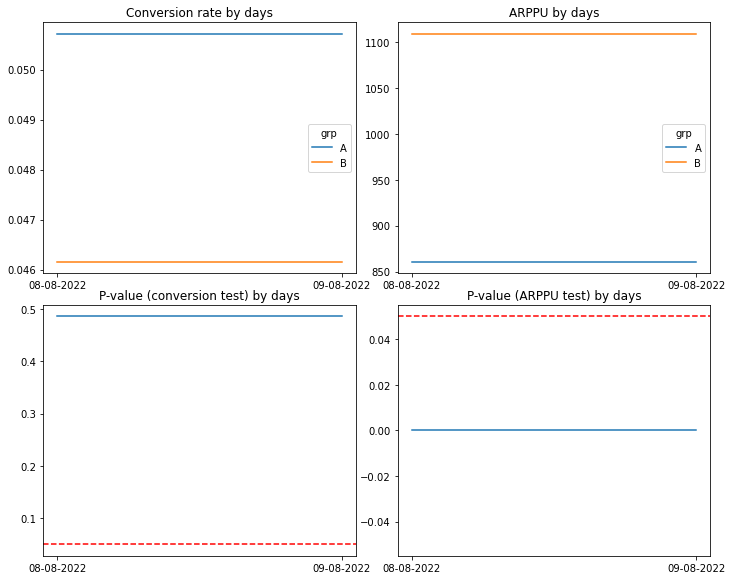

In [424]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.tight_layout()

g1 = sns.lineplot(data=conversion_graph, x='date', y='conversion', hue='grp', ax=axs[0][0])
g1.set(xlabel=None, ylabel=None)
g1.set_title('Conversion rate by days')

g2 = sns.lineplot(data=arppu_graph, x='date', y='ARPPU', hue='grp', ax=axs[0][1])
g2.set(xlabel=None, ylabel=None)
g2.set_title('ARPPU by days')

g3 = sns.lineplot(data=p_conversion_graph, x='date', y='p_value', ax=axs[1][0])
g3.set(xlabel=None, ylabel=None)
g3.set_title('P-value (conversion test) by days')
g3.axhline(0.05, ls='--', color='red')

g4 = sns.lineplot(data=p_arppu_graph, x='date', y='p_value', ax=axs[1][1])
g4.set(xlabel=None, ylabel=None)
g4.set_title('P-value (ARPPU test) by days')
g4.axhline(0.05, ls='--', color='red')